#### Author: Erinç Ada Ceylan
#### Company: Wellztech A.Ş.
#### Date: 2024-12-11
#### Description: Time Series Forecasting for Livestock Feeding.

In [1]:
#Checking whether GPU works or not. For complex models GPU is recommended.

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) are available for use.")
    except RuntimeError as e:
        print(e)

2024-12-11 21:54:02.600024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 21:54:02.626669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 21:54:02.655591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 21:54:02.667340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 21:54:02.691910: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0
Available GPUs: []


I0000 00:00:1733943245.742309   81189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-11 21:54:05.933860: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
#imports

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns #heatmap
from sklearn.preprocessing import MinMaxScaler

      SAMAN      ARPA      SLAJ       YEM        SU
0  1.623454  2.272836  2.516354  6.818507  1.298763
1  1.543873  2.161422  2.393003  6.484267  1.235098
2  1.378363  2.297272  2.909877  6.126058  1.225212
3  1.378363  2.297272  2.909877  6.126058  1.225212
4  1.378363  2.297272  2.909877  6.126058  1.225212


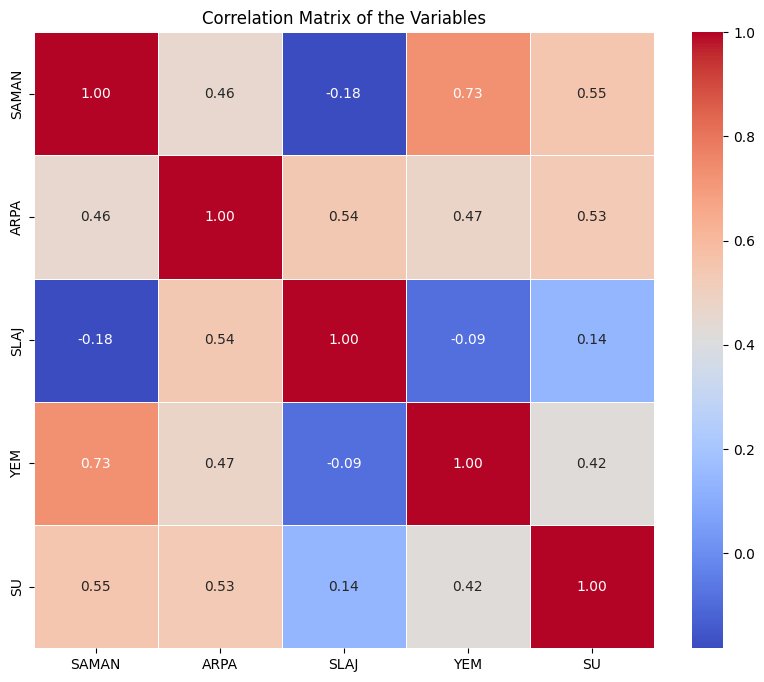

In [ ]:
#the correlation matrix shows us how much the data is related in itself.
# google "correlation calculation formula" to understand better

data = pd.read_csv("consecutive_feed.csv", delimiter=',')
df = data[["SAMAN","ARPA","SLAJ","YEM","SU"]] #taking the columns that we are interested in
print(df.head())

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of the Variables')
plt.show()

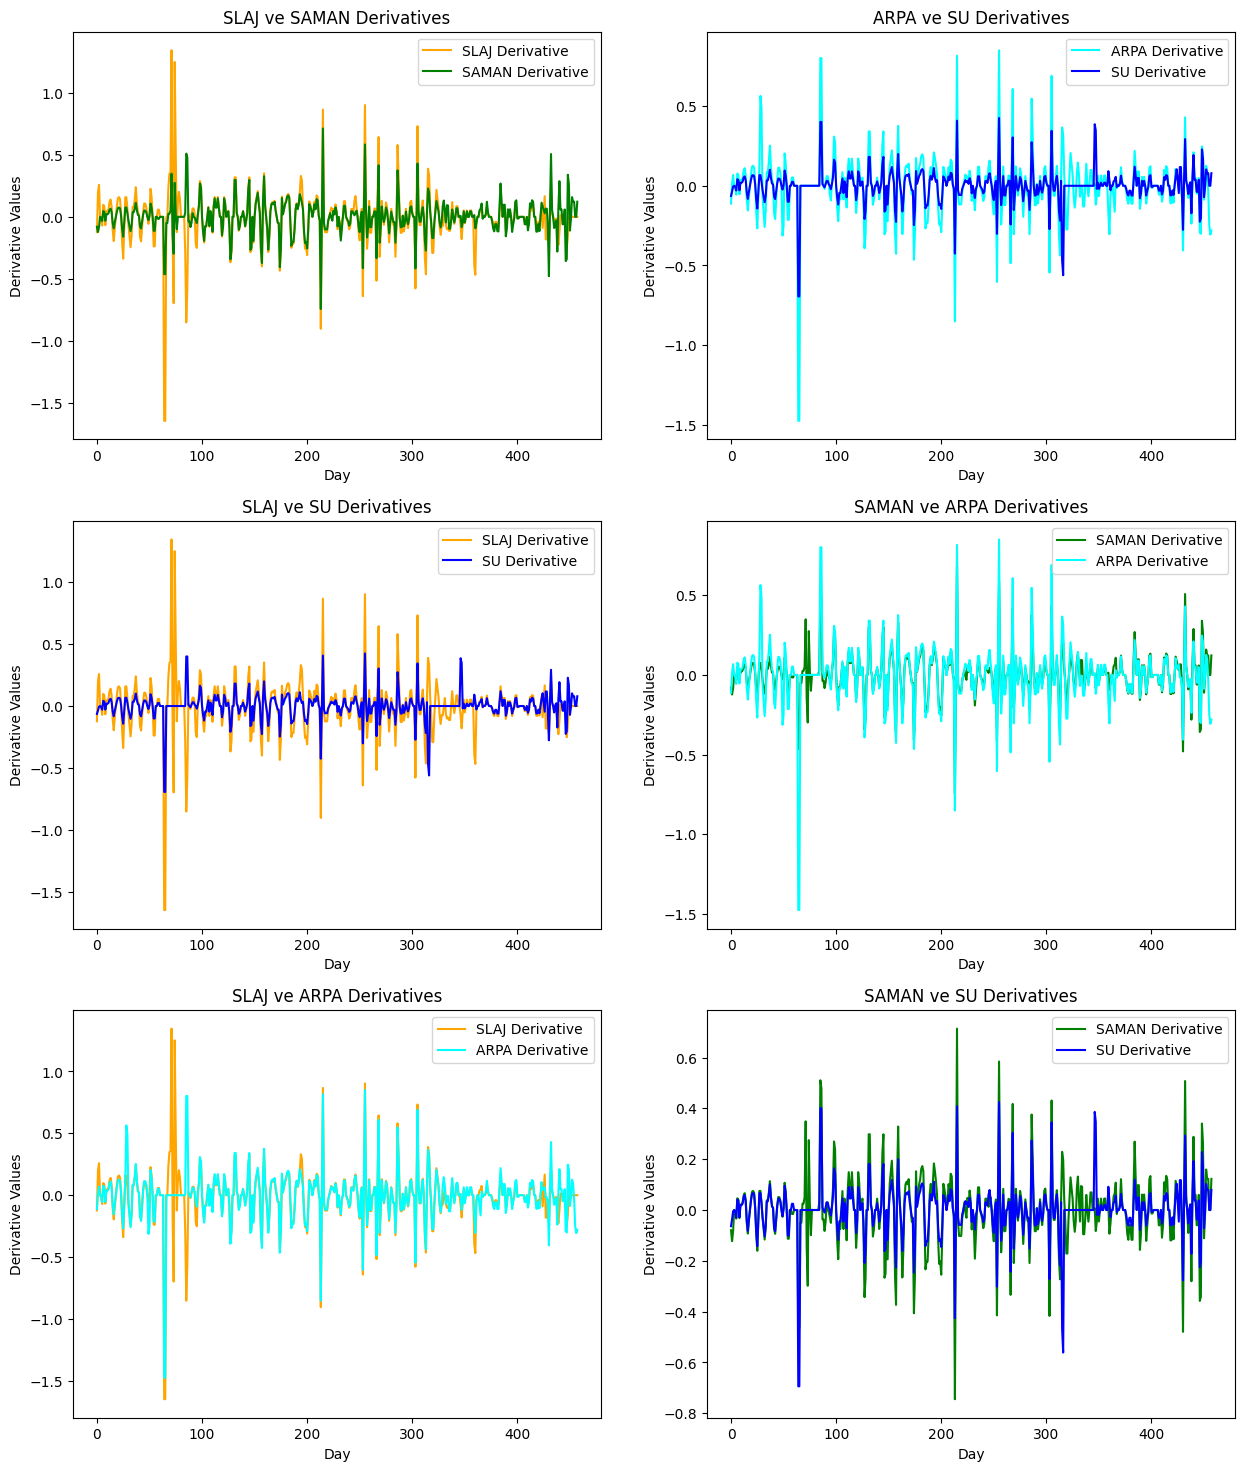

In [4]:
# the farm that you can interested in may be implementing some strategies such as 
#"similar decreasement or incerement". Thus a visualizoation of gradients can be useful.

df['SAMAN_derivative'] = np.gradient(df['SAMAN'])
df['ARPA_derivative'] = np.gradient(df['ARPA'])
df['SLAJ_derivative'] = np.gradient(df['SLAJ'])
df['YEM_derivative'] = np.gradient(df['YEM'])
df['SU_derivative'] = np.gradient(df['SU'])

fig, axs = plt.subplots(3, 2, figsize=(15, 18))

axs[0, 0].plot(df['SLAJ_derivative'], label='SLAJ Derivative', color='orange')
axs[0, 0].plot(df['SAMAN_derivative'], label='SAMAN Derivative', color='green')
axs[0, 0].set_title('SLAJ ve SAMAN Derivatives')
axs[0, 0].set_xlabel('Day')
axs[0, 0].set_ylabel('Derivative Values')
axs[0, 0].legend()

axs[0, 1].plot(df['ARPA_derivative'], label='ARPA Derivative', color='cyan')
axs[0, 1].plot(df['SU_derivative'], label='SU Derivative', color='blue')
axs[0, 1].set_title('ARPA ve SU Derivatives')
axs[0, 1].set_xlabel('Day')
axs[0, 1].set_ylabel('Derivative Values')
axs[0, 1].legend()

axs[1, 0].plot(df['SLAJ_derivative'], label='SLAJ Derivative', color='orange')
axs[1, 0].plot(df['SU_derivative'], label='SU Derivative', color='blue')
axs[1, 0].set_title('SLAJ ve SU Derivatives')
axs[1, 0].set_xlabel('Day')
axs[1, 0].set_ylabel('Derivative Values')
axs[1, 0].legend()

axs[1, 1].plot(df['SAMAN_derivative'], label='SAMAN Derivative', color='green')
axs[1, 1].plot(df['ARPA_derivative'], label='ARPA Derivative', color='cyan')
axs[1, 1].set_title('SAMAN ve ARPA Derivatives')
axs[1, 1].set_xlabel('Day')
axs[1, 1].set_ylabel('Derivative Values')
axs[1, 1].legend()

axs[2, 0].plot(df['SLAJ_derivative'], label='SLAJ Derivative', color='orange')
axs[2, 0].plot(df['ARPA_derivative'], label='ARPA Derivative', color='cyan')
axs[2, 0].set_title('SLAJ ve ARPA Derivatives')
axs[2, 0].set_xlabel('Day')
axs[2, 0].set_ylabel('Derivative Values')
axs[2, 0].legend()

axs[2, 1].plot(df['SAMAN_derivative'], label='SAMAN Derivative', color='green')
axs[2, 1].plot(df['SU_derivative'], label='SU Derivative', color='blue')
axs[2, 1].set_title('SAMAN ve SU Derivatives')
axs[2, 1].set_xlabel('Day')
axs[2, 1].set_ylabel('Derivative Values')
axs[2, 1].legend()


plt.show()

ARPA column index: 1, YEM column index: 3
Row 3 - ARPA: 0.6381578948629439, YEM: 0.7633697703214586
Row 4 - ARPA: 0.6381578948629439, YEM: 0.7633697703214586
Row 5 - ARPA: 0.6315789473099391, YEM: 0.753490096873463
Row 6 - ARPA: 0.6070074322048672, YEM: 0.7165907973899197
Row 7 - ARPA: 0.6743060823877295, YEM: 0.8176538786010911
Row 8 - ARPA: 0.6447368421381593, YEM: 0.7732494439258889
Row 9 - ARPA: 0.6447368421381593, YEM: 0.7732494439258889
Row 10 - ARPA: 0.6644736842415949, YEM: 0.8028884644263102
Row 11 - ARPA: 0.6644736842415949, YEM: 0.8028884644263102
Row 12 - ARPA: 0.6907894738980354, YEM: 0.8424071586875966
Row 13 - ARPA: 0.7171052632766863, YEM: 0.8819258527924482
Row 14 - ARPA: 0.7521613834326031, YEM: 0.934569992223527
Row 15 - ARPA: 0.7521613834326031, YEM: 0.934569992223527
Row 16 - ARPA: 0.7059760352515532, YEM: 0.8652129756784502
Row 17 - ARPA: 0.6663885940328788, YEM: 0.805764104331751
Row 18 - ARPA: 0.6663885940328788, YEM: 0.805764104331751
Row 19 - ARPA: 0.666388594

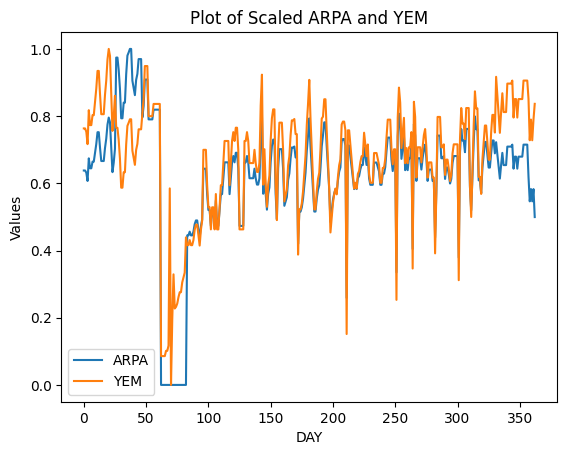

[[[0.59246714 0.63136986 0.68818729 ... 0.50924431 0.46730031 0.56321901]
  [0.55684129 0.60042036 0.65445262 ... 0.61616301 0.46458766 0.58724868]
  [0.48274786 0.63815789 0.79581043 ... 0.63676279 0.50241563 0.6156961 ]]

 [[0.55684129 0.60042036 0.65445262 ... 0.61616301 0.46458766 0.58724868]
  [0.48274786 0.63815789 0.79581043 ... 0.63676279 0.50241563 0.6156961 ]
  [0.48274786 0.63815789 0.79581043 ... 0.55044388 0.54295624 0.62011386]]

 [[0.48274786 0.63815789 0.79581043 ... 0.63676279 0.50241563 0.6156961 ]
  [0.48274786 0.63815789 0.79581043 ... 0.55044388 0.54295624 0.62011386]
  [0.48274786 0.63815789 0.79581043 ... 0.54543403 0.53580859 0.61446992]]

 ...

 [[0.68543434 0.6192469  0.34837335 ... 0.39420432 0.41440163 0.65168372]
  [0.58899498 0.54639432 0.30738825 ... 0.53793028 0.49843428 0.59500278]
  [0.63721466 0.58282061 0.3278808  ... 0.55044388 0.54295624 0.62011386]]

 [[0.58899498 0.54639432 0.30738825 ... 0.53793028 0.49843428 0.59500278]
  [0.63721466 0.58282061

In [ ]:
#naming the variables that we want to predict, one can add var_to_guess as much as he/she wants with also
#an update on the DL model.

#understanding window size logic is crucial. A window that stores partial data slides over the dataset.
#This allows a better Time Series forecasting prediction.
#https://www.youtube.com/watch?v=c0k-YLQGKjY&t=1515s watch this video to understand better.

var_to_guess_1 = "ARPA"
var_to_guess_2 = "YEM"
WINDOW_SIZE = 3

#function to convert the data to the feature set, and the label set that we want to predict.
def df_to_X_y(df, var_to_guess_1, var_to_guess_2, WINDOW_SIZE ):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    var_to_guess_1_index = df.columns.get_loc(var_to_guess_1)
    var_to_guess_2_index = df.columns.get_loc(var_to_guess_2)
    print(f"{var_to_guess_1} column index: {var_to_guess_1_index}, {var_to_guess_2} column index: {var_to_guess_2_index}")
    
    for i in range(len(df) - WINDOW_SIZE):
        X.append(df_as_np[i:i+WINDOW_SIZE, :])
        var_1_value = df_as_np[i+WINDOW_SIZE, var_to_guess_1_index]
        var_2_value = df_as_np[i+WINDOW_SIZE, var_to_guess_2_index]
        print(f"Row {i+WINDOW_SIZE} - {var_to_guess_1}: {var_1_value}, {var_to_guess_2}: {var_2_value}")
        y.append([var_1_value, var_2_value])
    return np.array(X), np.array(y)

# Splitting the data into training, validation, and test sets.
# The split points have been tried with the optimization code.
# But the computation runtime and effectiveness was low. Thus we stick to the general floats (0.8...)

split_1 = int(0.8 * len(df))
split_2 = int(0.9 * len(df))
df_train = df[:split_1]
df_val = df[split_1:split_2]
df_test = df[split_2:]

scalers = {}
scaled_train = pd.DataFrame()
scaled_val = pd.DataFrame()
scaled_test = pd.DataFrame()

#scaled every column seperately, with a fit for each sclaer fitted on the train set for the spesific variable.
for column in df.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train[column] = scaler.fit_transform(df_train[[column]]).ravel() #ravel flattens the array
    scaled_val[column] = scaler.transform(df_val[[column]]).ravel()
    scaled_test[column] = scaler.transform(df_test[[column]]).ravel()
    scalers[column] = scaler  

X_train, y_train = df_to_X_y(scaled_train, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)
X_val, y_val = df_to_X_y(scaled_val, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)
X_test, y_test = df_to_X_y(scaled_test, var_to_guess_1, var_to_guess_2, WINDOW_SIZE)

#plotting the features to see the similarities between their train sets.
plt.plot(y_train[:, 0], label=var_to_guess_1)
plt.plot(y_train[:, 1], label=var_to_guess_2)
plt.xlabel('DAY')
plt.ylabel('Values')
plt.title('Plot of Scaled ' + var_to_guess_1 + ' and ' + var_to_guess_2)
plt.legend()
plt.show()

In [6]:
"""Defining a sequential model with LSTM layers and dropout for regularization.
LSTM layers are used for time series data processing, and dropout layers prevent overfitting.
Adding the input layer with the shape corresponding to the time window size and number of features.
Dropout randomly sets a fraction of input units to zero during training, 
preventing overfitting by forcing the model to rely on multiple pathways and improving generalization.
The L2 regularizer adds a penalty to the loss function based on the squared values of the model's weights. 
This helps prevent overfitting by discouraging large weights, promoting simpler models.
Batch normalization normalizes the inputs of each layer by scaling and shifting them to have a mean of 0 and
a standard deviation of 1. This helps stabilize and speed up training by reducing internal covariate shift."""

model = Sequential()
model.add(InputLayer(input_shape=(WINDOW_SIZE, X_train.shape[2])))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(7.74428057152964e-05)))
model.add(Dropout(0.1))
model.add(LSTM(32, kernel_regularizer=l2(7.74428057152964e-05)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(2, activation='linear'))
model.summary()

# Using ReduceLROnPlateau to adjust the learning rate when the validation loss stops improving.
# Applying early stopping to halt training if validation loss doesn't improve for 10 epochs.
# Compiling the model with Huber loss, Adam optimizer, and RMSE as the evaluation metric.
# Loss and optimizer functions are also optimized while hyper parameter tuning.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=2, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model.compile(loss='huber', optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[reduce_lr, early_stopping])


test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test RMSE: {test_rmse}")


/home/erincada/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,306 (126.20 KB)

 Trainable params: 32,242 (125.95 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1566 - root_mean_squared_error: 0.5015 - val_loss: 0.0682 - val_root_mean_squared_error: 0.2999 - learning_rate: 0.0100
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - root_mean_squared_error: 0.1528 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2412 - learning_rate: 0.0100
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228 - root_mean_squared_error: 0.1146 - val_loss: 0.0481 - val_root_mean_squared_error: 0.2664 - learning_rate: 0.0100
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.0995 - val_loss: 0.0354 - val_root_mean_squared_error: 0.2279 - learning_rate: 0.0100
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - root_mean_squared_error: 0.1031 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2681 - learning_rate: 0.0100
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - root_mean_squared_er

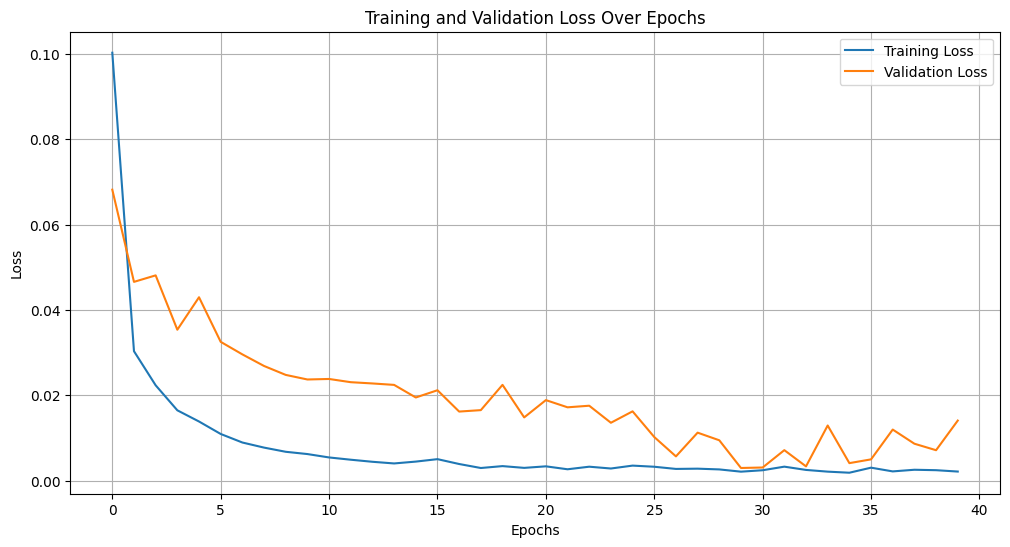

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


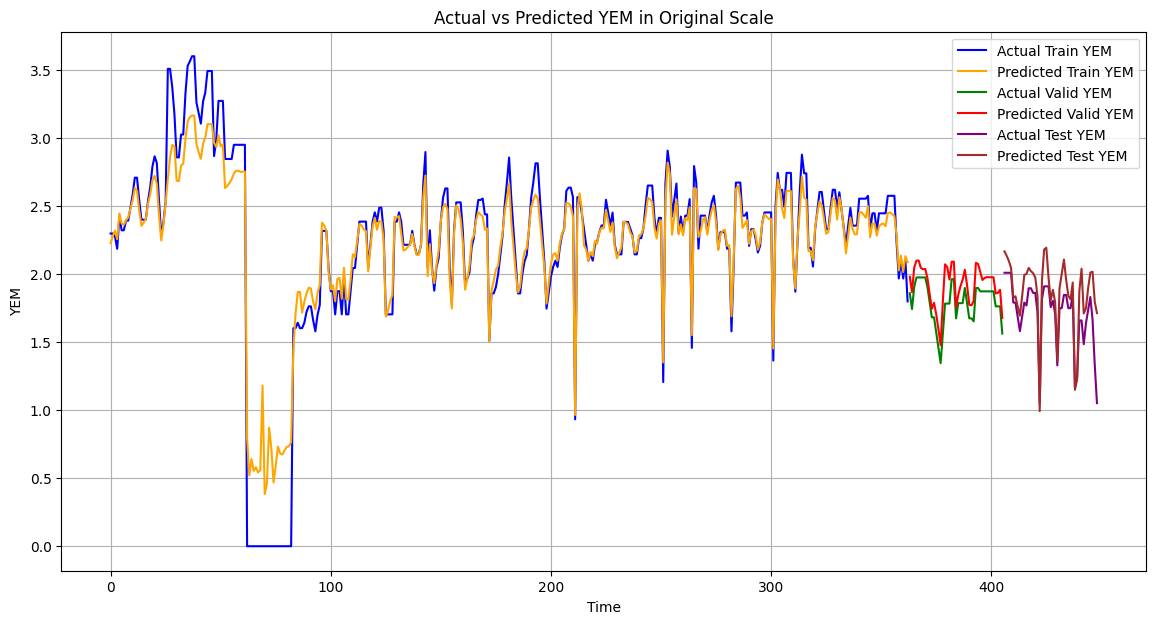

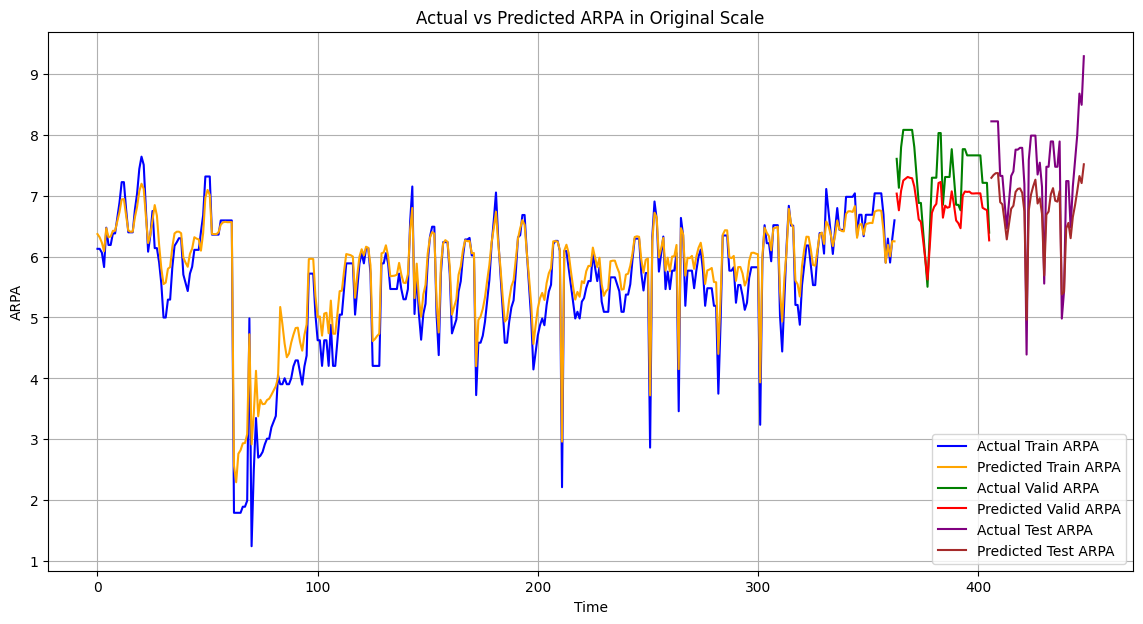

In [7]:
#plotting the model loss evaluation over the epochs.
#plotting the results for the whole dataset predictions. 
# as far as it has been noticed, well optimized models tend to predict test set better.

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = np.column_stack([scalers[var].inverse_transform(y_train_pred[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])
y_train_inverse = np.column_stack([scalers[var].inverse_transform(y_train[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])
y_val_pred_inverse = np.column_stack([scalers[var].inverse_transform(y_val_pred[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])
y_val_inverse = np.column_stack([scalers[var].inverse_transform(y_val[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])
y_test_pred_inverse = np.column_stack([scalers[var].inverse_transform(y_test_pred[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])
y_test_inverse = np.column_stack([scalers[var].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel() for i, var in enumerate([var_to_guess_1, var_to_guess_2])])

def plot_predictions(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, label):
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_train)), y_train, label=f"Actual Train {label}", color='blue')
    plt.plot(range(len(y_train)), y_train_pred, label=f"Predicted Train {label}", color='orange')
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val, label=f"Actual Valid {label}", color='green')
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val_pred, label=f"Predicted Valid {label}", color='red')
    plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, label=f"Actual Test {label}", color='purple')
    plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test_pred, label=f"Predicted Test {label}", color='brown')
    plt.xlabel('Time')
    plt.ylabel(label)
    plt.title(f"Actual vs Predicted {label} in Original Scale")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_train_inverse[:, 0], y_train_pred_inverse[:, 0], y_val_inverse[:, 0], y_val_pred_inverse[:, 0], y_test_inverse[:, 0], y_test_pred_inverse[:, 0], var_to_guess_2)
plot_predictions(y_train_inverse[:, 1], y_train_pred_inverse[:, 1], y_val_inverse[:, 1], y_val_pred_inverse[:, 1], y_test_inverse[:, 1], y_test_pred_inverse[:, 1], var_to_guess_1)
